In [11]:
import numpy as np
import pandas as pd
import librosa
from tqdm import tqdm
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dropout, Dense
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle


%matplotlib inline

In [3]:
file_properties = pd.read_csv('complete_index.csv')

In [18]:
file_properties['length'].sum() / 60

159.51497127739987

In [4]:
train = file_properties[file_properties['set'] == 'train']
# val = file_properties[file_properties['set'] == 'validation']
test = file_properties[file_properties['set'] == 'test']
train.drop('Unnamed: 0', inplace = True, axis = 1)
# val.drop('Unnamed: 0', inplace = True, axis = 1)
test.drop('Unnamed: 0', inplace = True, axis = 1)

/Users/alex/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [5]:
# Need to drop file from RAVDESS that is too short after noise level detection
# This file causes problems in testing

test[test['length'] == test['length'].min()]

,dataset,filename,actor,emotion,length,gender,set
1010,RAVDESS,clean/RAVDESS/Actor_09/03-01-04-01-01-01-09.wav,09,sad,0.449977,male,test


In [6]:
test.drop(index = 1010, inplace = True)

In [8]:
# Class distribution in training set
class_dist = train['emotion'].value_counts()

# As probability
prob_dist = class_dist / class_dist.sum()

In [9]:
classes = pd.DataFrame({'emotion': ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgusted', 'surprised']})

In [10]:
# Create a configuration class to help if I want to change parameters later

class Config:
    def __init__(self, n_mfcc = 26, n_feat = 13, n_fft = 552, sr = 22050, window = 0.4, test_shift = 0.1):
        self.n_mfcc = n_mfcc
        self.n_feat = n_feat
        self.n_fft = n_fft
        self.sr = sr
        self.window = window
        self.step = int(sr * window)
        self.test_shift = test_shift
        self.shift = int(sr * test_shift)
        
config = Config()

In [69]:
#### This function doesn't scale audio files properly ####
#### Use build_train_feats() instead                  ####


# def build_rand_feat():
#     '''
#     This function collects n_samples of audio. Each sample is of length config.window and picked randomly from the training set.
#     '''
#     X = [] # list for each sample features
#     y = [] # list for each sample label
    
#     # initialize min and max values, use for scaling later
#     _min, _max = float('inf'), -float('inf')
    
#     # iterate through number of samples
#     for _ in tqdm(range(n_samples)):
        
#         # choose a random class
#         rand_class = np.random.choice(prob_dist.index, p = prob_dist)
        
#         # choose a random file in class
#         file_ind = np.random.choice(train[train['emotion'] == rand_class].index)
#         #print(file_ind)
        
#         wav, sr = librosa.load(train.loc[file_ind, 'filename'])                      # load file
#         label = train.loc[file_ind, 'emotion']                                       # pull class label
#         #print(label)
#         rand_ind = np.random.randint(0, wav.shape[0] - config.step)                  # choose random starting point for window
#         sample = wav[rand_ind: rand_ind + config.step]                               # create windowed sample
        
#         # Create 13 mfccs from X_sample at 0.025s intervals (0.025s determined by config.n_fft)
#         X_sample = librosa.feature.mfcc(sample, sr, n_mfcc = config.n_mfcc, n_fft = config.n_fft,
#                                         hop_length = config.n_fft)[1:config.n_feat + 1]
        
#         _min = min(np.amin(X_sample), _min)
#         _max = max(np.amax(X_sample), _max) # check min and max values
#         X.append(X_sample) # append sample to X
#         y.append(classes[classes['emotion'] == label].index[0]) # append label to y (as 0, 7 value)
        
#     X, y = np.array(X), np.array(y)
#     X = (X - _min)/(_max - _min) # scale X data such that it is all between 0 and 1
#     X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1) # need to add this 1 for the CNN
#     y = to_categorical(y, num_classes = 8) # one hot y
    
#     return X, y

In [425]:
def build_train_feats():
    X = []
    y = []
    
    for row in train.iterrows():
        
        # Initialize min and max values for each file for scaling
        _min, _max = float('inf'), -float('inf')
        
        # Load the file
        wav, sr = librosa.load(row[1]['filename'])
        
        # Create an array to hold features for each window generated from specific file
        Xf = []
        
        # Create randomly selected 0.4s windows from each file. Select 1 random window for every 0.1s of audio in file.
        
        n_samples =  int(10 * float(row[1]['length'])) 
              
        for i in range(n_samples):
            
            # Get the numerical label for the emotion of the file
            # This needs to be in for loop so that y.shape and X.shape match up
            y.append(classes[classes['emotion'] == row[1]['emotion']].index[0])
            
            # choose random starting point for window
            rand_ind = np.random.randint(0, wav.shape[0] - config.step)
            # create windowed sample
            X_sample = wav[rand_ind: rand_ind + config.step]
            # generate mfccs from sample
            X_mfccs = librosa.feature.mfcc(X_sample, sr, n_mfcc = config.n_mfcc, n_fft = config.n_fft,
                                            hop_length = config.n_fft)[1:config.n_feat + 1]
             # check min and max values
            _min = min(np.amin(X_mfccs), _min)
            _max = max(np.amax(X_mfccs), _max)
            # add features of window to X
            Xf.append(X_mfccs)
        
        # Put window data for file into array and scale
        Xf = np.array(Xf)
        Xf = (Xf - _min) / (_max - _min)
        
        # Now that data is scaled, pick out each window from Xf and add that to X
        for ar in Xf:
            X.append(ar)
        
    
    # Once windows have been taken from every file reshape X
    X = np.array(X)
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    y = to_categorical(y, num_classes = 7)
    
    return X, y

In [426]:
X, y = build_train_feats()

In [427]:
y_flat = np.argmax(y, axis = 1)
class_weight = compute_class_weight('balanced', np.unique(y_flat), y_flat) # This will assign slightly more weight to the neutral class

input_shape = (X.shape[1], X.shape[2], 1) # Required input shape for CNN

In [428]:
# Function to define CNN

def create_cnn():
    model = Sequential()
    model.add(Conv2D(16, (3,3), activation = 'relu', strides = (1,1), padding = 'same', input_shape = input_shape))
    model.add(Conv2D(32, (3,3), activation = 'relu', strides = (1,1), padding = 'same'))
    model.add(Conv2D(64, (3,3), activation = 'relu', strides = (1,1), padding = 'same'))
    model.add(Conv2D(128, (3,3), activation = 'relu', strides = (1,1), padding = 'same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation ='relu'))
    model.add(Dense(64, activation ='relu'))
    model.add(Dense(7, activation ='softmax'))
    model.summary()
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])
    return model
    

In [429]:
# Create the CNN and fit it

# model = create_cnn()
# model.fit(X, y, epochs = 25, batch_size = 32, shuffle = True, class_weight = class_weight)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 13, 16, 16)        160       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 13, 16, 32)        4640      
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 13, 16, 64)        18496     
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 13, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 8, 128)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 6, 8, 128)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 6144)              0         
__________

In [13]:
def test_model(model, input_files):
    '''
    This function benchmarks the input model against the test set by windowing test file data.
    Returns a dataframe of class probabilities, overall predictions, ground truth, and filename.
    Also returns accuracy metric.
    '''
    
    # initialize a total results list
    all_results = []
    
    for row in input_files.iterrows():
        # Initialize a local results list
        local_results = []
        
        # Initialize min and max values for each file for scaling
        _min, _max = float('inf'), -float('inf')
        
        # Get the numerical label for the emotion of the file
        label = classes[classes['emotion'] == row[1]['emotion']].index[0]
        
        # Load the file
        wav, sr = librosa.load(row[1]['filename'])
        
        # Create an array to hold features for each window
        X = []
        
        # Iterate over sliding 0.4s windows of the audio file
        for i in range(int((wav.shape[0]/sr-config.window)/config.test_shift)):
            X_sample = wav[i*config.shift: i*config.shift + config.step] # slice out 0.4s window
            X_mfccs = librosa.feature.mfcc(X_sample, sr, n_mfcc = config.n_mfcc, n_fft = config.n_fft,
                                            hop_length = config.n_fft)[1:config.n_feat + 1] # generate mfccs from sample
            
            _min = min(np.amin(X_mfccs), _min)
            _max = max(np.amax(X_mfccs), _max) # check min and max values
            X.append(X_mfccs) # add features of window to X
        
        # Put window data into array, scale, then reshape
        X = np.array(X)
        X = (X - _min) / (_max - _min)
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
        
        # Feed data for each window into model for prediction
        for i in range(X.shape[0]):
            window = X[i].reshape(1, X.shape[1], X.shape[2], 1)
            local_results.append(model.predict(window))
        
        # Aggregate predictions for file into one then append to all_results
        local_results = (np.sum(np.array(local_results), axis = 0)/len(local_results))[0]
        local_results = list(local_results)
        prediction = np.argmax(local_results)
        local_results.append(prediction)
        local_results.append(label)
        local_results.append(row[1]['filename'])
        all_results.append(local_results)
        
    # Turn all results into a dataframe
    df_cols = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgusted', 'surprised', 'prediction', 'ground_truth', 'filename']
    all_results = pd.DataFrame(all_results, columns = df_cols)
    
    # Compute accuracy
    corrects = (all_results['prediction'] == all_results['ground_truth']).value_counts().loc[True]
    incorrects = (all_results['prediction'] == all_results['ground_truth']).value_counts().loc[False]
    accuracy = corrects / all_results.shape[0]
    print(f'Validation Set Accuracy: {accuracy}')

    return all_results, accuracy

In [12]:
model = pickle.load(open('cnn_ep25_mfccOnly_moreData.pkl', 'rb'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [14]:
results, accuracy = test_model(model, test)

Validation Set Accuracy: 0.829021372328459


In [15]:
results.to_csv('test_results.csv')

In [432]:
# This version of the model that's been trained on more data is much more accurate on the validation set than the previous version.
# 83% vs 67%!!!
results['prediction'].value_counts()

0    144
2    141
5    129
4    128
3    122
6    120
1    105
Name: prediction, dtype: int64

In [433]:
# This function tells us if our model was close to making correct predictions

def is_model_close(results, threshold):
    close = []

    for row in results.iterrows():
        maybes = (row[1][list(classes['emotion'])] > threshold)
        close.append(classes.loc[row[1]['ground_truth'], 'emotion'] in list(maybes[maybes == True].index))
    
    close = pd.DataFrame(close)
    
    acc = close[0].value_counts()[True]/(results.shape[0])
    
    print('At threshold of %s accuracy is %s' % (threshold, acc))

    return close[0].value_counts()

In [434]:
# Seems the model is typically not too far off
is_model_close(results, 0.2)

At threshold of 0.2 accuracy is 0.8965129358830146


True     797
False     92
Name: 0, dtype: int64

In [406]:
def plot_confusion(truth, pred, normalize = True):
    cm = confusion_matrix(truth, pred)
    
    if normalize == True:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, cmap = 'Blues', annot = True,
                xticklabels = classes['emotion'],
                yticklabels = classes['emotion'])
    plt.xlabel('Prediction')
    plt.ylabel('Truth');


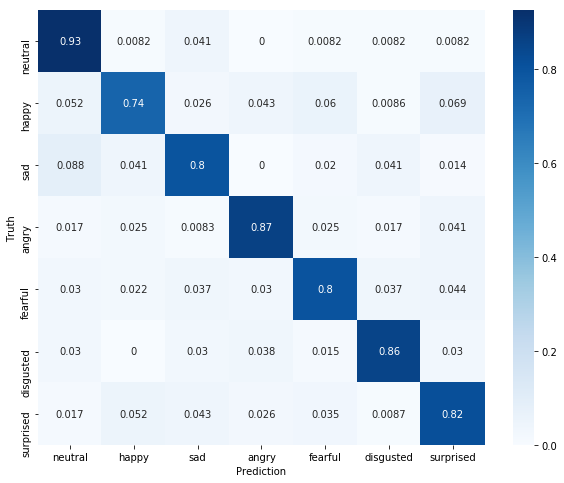

In [435]:
plot_confusion(results['ground_truth'], results['prediction'])

In [436]:
# Determine confusion matrix for training examples, is it similar to that of the test set?

In [413]:
def train_results(X, y, plot = True, normalize = True):
    '''
    Determine model performance on the training set. Plot a confusion matrix unless plot set to False.
    '''
    
    # Create lists to hold truth and predictions. Initialize counter for correct predictions.
    truth = []
    pred = []
    corrects = 0

    # iterate through the list of training examples
    for i in range(X.shape[0]):
        tr = np.argmax(y[i]) # determine truth
        truth.append(tr)
        train_point = X[i].reshape(1, X.shape[1], X.shape[2], 1)
        pr = np.argmax(model.predict(train_point)) # make prediction
        pred.append(pr)
        
        # increment counter if correct
        if pr == tr:
            corrects += 1 
    
    # determine accuracy from number of correct predictions
    accuracy = corrects / X.shape[0]
    
    # plot confusion matrix using previously defined function
    if plot == True:
        plot_confusion(truth, pred, normalize = normalize)
    
    return accuracy
    
    

0.9468815359038988


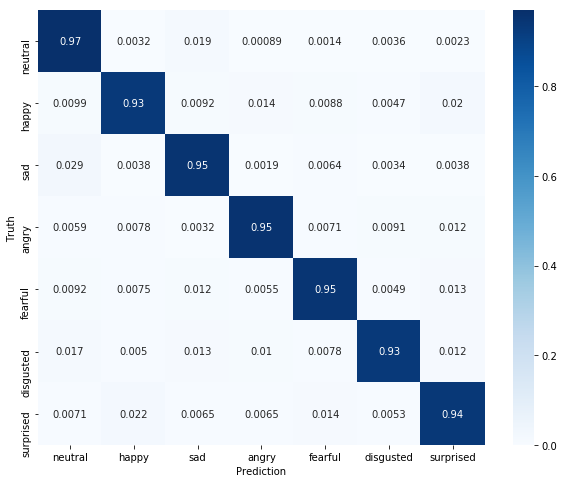

In [437]:
# Model is very accurate on the training set, no surprise here.
acc = train_results(X, y)
print(acc)

In [439]:
pickle.dump(model, open('cnn_ep25_mfccOnly_moreData1.pkl', 'wb'))